In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import json
import re

In [20]:
# user_inf
account_opened = pd.read_csv("gotrade - account opened.csv")
kyc_started = pd.read_csv("gotrade - kyc started.csv")
kyc_completed = pd.read_csv("gotrade - kyc completed.csv")
users_data = pd.read_csv("gotrade - users data.csv")

churn_status_tracked = pd.read_csv("gotrade - churn status tracked.csv")
deposit_paid = pd.read_csv("gotrade - deposit paid.csv")

segment_event_tracked = pd.read_csv("gotrade - segment event tracked.csv")
segment_tap_event_tracked = pd.read_csv("gotrade - segment tap event tracked.csv")
session_data = pd.read_csv("gotrade - session data.csv")
trade_order_level_filled = pd.read_csv("gotrade - trade order level filled.csv")
withdrawal_executed = pd.read_csv("gotrade - withdrawal executed.csv")

account_opened_sorted = account_opened.sort_values(by='identifier', ascending=True)
account_opened_sorted.reset_index(drop=True, inplace=True)
kyc_completed_sorted = kyc_completed.sort_values(by='identifier', ascending=True)
kyc_completed_sorted.reset_index(drop=True, inplace=True)
kyc_started_sorted = kyc_started.sort_values(by='identifier', ascending=True)
kyc_started_sorted.reset_index(drop=True, inplace=True)
users_data_sorted = users_data.sort_values(by='identifier', ascending=True)
users_data_sorted.reset_index(drop=True, inplace=True)
# 752934
churn_status_tracked_sorted = churn_status_tracked.sort_values(by='identifier', ascending=True)
churn_status_tracked_sorted.reset_index(drop=True, inplace=True)
# 11074
deposit_paid_sorted = deposit_paid.sort_values(by='identifier', ascending=True)
deposit_paid_sorted.reset_index(drop=True, inplace=True)
# 4971560
segment_event_tracked_sorted = segment_event_tracked.sort_values(by='identifier', ascending=True)
segment_event_tracked_sorted.reset_index(drop=True, inplace=True)
# 12922536
segment_tap_event_tracked_sorted = segment_tap_event_tracked.sort_values(by='identifier', ascending=True)
segment_tap_event_tracked_sorted.reset_index(drop=True, inplace=True)
# 772058
session_data_sorted = session_data.sort_values(by='identifier', ascending=True)
session_data_sorted.reset_index(drop=True, inplace=True)
# 252496
trade_order_level_filled_sorted = trade_order_level_filled.sort_values(by='identifier', ascending=True)
trade_order_level_filled_sorted.reset_index(drop=True, inplace=True)
withdrawal_executed_sorted = withdrawal_executed.sort_values(by='identifier', ascending=True)
withdrawal_executed_sorted.reset_index(drop=True, inplace=True)

In [4]:
user_inf = pd.merge(account_opened_sorted, kyc_started_sorted, on='identifier', how='inner')
user_inf = pd.merge(user_inf, kyc_completed_sorted, on='identifier', how='inner')

In [5]:
column_names = ["identifier",
                "Total trading",
                "Deposit",
                "Buy",
                "Trading frequency",
                "Account setup time",
                "Churn percentage",
                "Session length"
               ]

df = pd.DataFrame(columns=column_names, dtype='int')

In [6]:
no_trading_account = []
only_buy_account = []
data_completed = datetime.strptime('2023-08-29 23:59:59', '%Y-%m-%d %H:%M:%S')
for i in range(1,2701,1):
    trade_time = []
    temp_df_trade = trade_order_level_filled_sorted[trade_order_level_filled_sorted['identifier'] == i]
    temp_df_deposit = deposit_paid_sorted[deposit_paid_sorted['identifier'] == i]
    temp_df_churn = churn_status_tracked_sorted[churn_status_tracked_sorted['identifier'] == i]
    temp_df_session = session_data_sorted[session_data_sorted['identifier'] == i]
    symbols = list(set(temp_df_trade['symbol']))
    
    if len(temp_df_trade) == 0:
        no_trading_account.append(i)
        continue
    
    if len(temp_df_trade[temp_df_trade['side'] == "sell"]) == 0:
        only_buy_account.append(i)
        continue
    
    date_kyc_started_at = datetime.strptime(user_inf['kyc_started_at'][i-1], '%Y-%m-%d %H:%M:%S')
    date_account_opened_at = datetime.strptime(user_inf['account_opened_at'][i-1], '%Y-%m-%d %H:%M:%S')
    account_setup_time = abs(date_account_opened_at - date_kyc_started_at).total_seconds()/3600
    account_existing_days = abs(data_completed - date_account_opened_at).days + 1
    
    temp_df_churn_1 = temp_df_churn[temp_df_churn['is_churn'] == 1]
    
    
    Deposit_value = sum(temp_df_deposit['deposit_value_usd'])
    Buy_value = sum(temp_df_trade[temp_df_trade['side'] == 'buy']['trade_value_usd'])
    Buy_count = len(temp_df_trade[temp_df_trade['side'] == 'buy'])
    churn_percentage = len(temp_df_churn[temp_df_churn['is_churn'] == 1])/int(account_existing_days)
    
    for sub_symbol in symbols:
        max_day = max(temp_df_trade[temp_df_trade['symbol'] == sub_symbol]['trade_order_level_filled_at'])
        min_day = min(temp_df_trade[temp_df_trade['symbol'] == sub_symbol]['trade_order_level_filled_at'])

        date_max = datetime.strptime(max_day, '%Y-%m-%d %H:%M:%S')
        date_min = datetime.strptime(min_day, '%Y-%m-%d %H:%M:%S')

        difference = abs(date_max - date_min).total_seconds()/3600
        if difference == 0:
            continue
        trade_time.append(difference/len(temp_df_trade[temp_df_trade['symbol'] == sub_symbol]))
        
    Trading_frequency = np.mean(trade_time)
    session_length = sum(temp_df_session['session_length'])
        
    df.loc[i-1] = [int(i),
                   len(temp_df_trade),
                   round(Deposit_value,2)/len(temp_df_deposit),
                   round(Buy_value,2)/Buy_count,
                   Trading_frequency,
                   round(account_setup_time,2),
                   churn_percentage,
                   len(temp_df_session['session_length'])]

df[df.columns.tolist()[0:1]] = df[df.columns.tolist()[0:1]].astype(int)

In [32]:
df.reset_index(drop=True, inplace=True)
df

,identifier,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length
0,1,3.0,10.320000,9.940000,55.394352,2.11,0.0,29.0
1,2,17.0,23.840000,1.969231,3432.536691,28.85,0.0,515.0
2,3,11.0,16.135000,6.416667,965.519824,26.52,0.0,195.0
3,4,10.0,17.185000,6.456000,2689.766296,25.94,0.0,363.0
4,5,8.0,13.962500,15.248000,2508.149028,5.39,0.0,479.0
...,...,...,...,...,...,...,...,...
2304,2694,19.0,4.820000,2.112000,31.598958,0.78,0.0,33.0
2305,2695,20.0,14.575000,2.235882,10.696481,0.82,0.0,48.0
2306,2696,48.0,986.048333,150.157805,11.224264,2.89,0.0,88.0
2307,2698,9.0,147.555000,109.808000,18.262014,0.61,0.0,30.0


In [33]:
df_umap = pd.read_csv("umap.csv",index_col=0)

In [34]:
df_umap

,UMAP_Component_1,UMAP_Component_2,UMAP_Component_3
0,11.473035,8.233886,1.818276
1,1.026672,2.081058,3.263856
2,4.165209,2.640270,0.544242
3,1.333003,2.079877,2.815917
4,1.359954,2.082016,2.775601
...,...,...,...
2304,11.453746,8.396506,1.790273
2305,11.064062,8.777267,1.447537
2306,0.506320,6.095545,0.640710
2307,8.764336,6.467962,2.617160


In [35]:
result_ump = pd.read_csv("1234.csv")
result_ump

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster
0,3,10.320000,9.940000,55.394352,2.11,0.0,29,0
1,17,23.840000,1.969231,3432.536691,28.85,0.0,515,2
2,11,16.135000,6.416667,965.519824,26.52,0.0,195,2
3,10,17.185000,6.456000,2689.766296,25.94,0.0,363,2
4,8,13.962500,15.248000,2508.149028,5.39,0.0,479,2
...,...,...,...,...,...,...,...,...
2304,19,4.820000,2.112000,31.598958,0.78,0.0,33,0
2305,20,14.575000,2.235882,10.696481,0.82,0.0,48,0
2306,48,986.048333,150.157805,11.224264,2.89,0.0,88,3
2307,9,147.555000,109.808000,18.262014,0.61,0.0,30,0


In [37]:
cluster_0 = result_ump[result_ump['cluster'] == 0]
cluster_0

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
0,3,10.320,9.940000,55.394352,2.11,0.0,29,0,1
5,2,120.335,100.000000,47.352917,108.46,0.0,40,0,7
8,38,27.540,9.776190,385.078740,98.21,0.0,176,0,11
17,35,171.665,51.268421,199.077298,0.76,0.0,110,0,23
20,2,27.020,28.900000,72.000694,93.49,0.0,182,0,27
...,...,...,...,...,...,...,...,...,...
2303,10,4.640,2.887143,32.150875,1.24,0.0,26,0,2693
2304,19,4.820,2.112000,31.598958,0.78,0.0,33,0,2694
2305,20,14.575,2.235882,10.696481,0.82,0.0,48,0,2695
2307,9,147.555,109.808000,18.262014,0.61,0.0,30,0,2698


In [38]:
cluster_1 = result_ump[result_ump['cluster'] == 1]
cluster_1

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
10,27,33.185000,6.465000,1528.316229,0.53,0.338491,126,1,13
12,8,86.865000,93.627500,36.212083,6476.95,0.587045,103,1,16
13,17,256.705000,82.127500,336.312760,3982.68,0.304843,159,1,18
18,41,40.615000,30.696400,251.718908,5976.57,0.000000,226,1,25
19,37,74.736667,24.010000,533.223029,96.67,0.571150,546,1,26
...,...,...,...,...,...,...,...,...,...
2163,3,8.460000,9.860000,465.447778,188.82,0.076923,38,1,2505
2170,4,52.600000,31.275000,222.408819,14.69,0.142857,118,1,2514
2235,19,82.848333,31.261250,224.157680,0.58,0.191489,134,1,2589
2244,17,109.625000,57.394615,204.257600,197.42,0.371429,153,1,2601


In [39]:
cluster_2 = result_ump[result_ump['cluster'] == 2]
cluster_2

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
1,17,23.8400,1.969231,3432.536691,28.85,0.0,515,2,2
2,11,16.1350,6.416667,965.519824,26.52,0.0,195,2,3
3,10,17.1850,6.456000,2689.766296,25.94,0.0,363,2,4
4,8,13.9625,15.248000,2508.149028,5.39,0.0,479,2,5
21,3,10.3600,1.415000,1596.054722,20.85,0.0,72,2,28
...,...,...,...,...,...,...,...,...,...
1968,5,87.5400,97.185000,1146.143333,0.89,0.0,322,2,2283
1979,10,40.9080,34.566667,540.526192,2.51,0.0,103,2,2294
2002,3,5.0500,6.950000,1070.726806,512.00,0.0,78,2,2321
2027,18,5.0500,0.996154,1069.225476,67.15,0.0,40,2,2348


In [40]:
cluster_3 = result_ump[result_ump['cluster'] == 3]
cluster_3

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
6,55,45.702174,20.225192,615.072281,10.13,0.040619,859,3,8
7,551,796.836250,973.134400,26.832961,0.46,0.404255,531,3,10
9,58,87.555000,180.094000,470.210740,74.68,0.000000,945,3,12
11,20,10.000000,11.735714,219.453014,41.09,0.755340,2024,3,15
14,16,819.995000,627.501250,1079.768229,145.35,0.318982,479,3,19
...,...,...,...,...,...,...,...,...,...
2249,4,357.380000,127.566667,0.128125,126.47,0.000000,23,3,2609
2270,4,329.110000,331.945000,77.252431,0.48,0.000000,17,3,2642
2277,11,261.548000,155.454444,17.246929,3.67,0.000000,208,3,2649
2282,4,328.120000,89.450000,252.000000,25.67,0.000000,26,3,2660


In [41]:
cluster_0.describe()

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
count,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.0,787.000000
mean,26.503177,29.402390,24.565386,155.529223,94.381398,0.000408,133.353240,0.0,1771.512071
std,33.697780,40.032493,50.490606,148.926368,200.821059,0.005192,93.084559,0.0,710.872782
min,2.000000,4.630000,0.870000,0.009583,0.460000,0.000000,4.000000,0.0,1.000000
25%,7.000000,6.545000,3.827566,29.407917,1.135000,0.000000,58.000000,0.0,1271.000000
50%,15.000000,10.210000,8.000000,105.418324,9.820000,0.000000,111.000000,0.0,1953.000000
75%,32.500000,33.132500,19.565873,250.143689,70.605000,0.000000,189.000000,0.0,2376.000000
max,276.000000,200.890000,465.418247,693.333333,1266.350000,0.093407,422.000000,0.0,2700.000000


In [42]:
cluster_1.describe()

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.0,466.000000
mean,75.639485,65.729853,70.801484,291.378167,1388.507468,0.421462,290.519313,1.0,1118.884120
std,153.109557,97.792005,178.862667,326.951391,2595.363664,0.252170,224.195155,0.0,713.633362
min,2.000000,4.690000,1.000000,0.007222,0.410000,0.000000,7.000000,1.0,13.000000
25%,13.000000,10.012500,7.062321,85.165006,2.902500,0.240611,118.000000,1.0,502.250000
50%,27.000000,19.867857,14.790833,183.035201,40.465000,0.433608,227.500000,1.0,1094.500000
75%,67.000000,74.026000,48.249808,375.305770,994.160000,0.638954,405.000000,1.0,1699.250000
max,1395.000000,652.962000,1921.163830,2316.508750,11711.990000,0.875969,1055.000000,1.0,2648.000000


In [43]:
cluster_2.describe()

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.0,338.000000
mean,17.603550,44.672089,24.683376,1475.573988,130.133018,0.014643,182.248521,2.0,985.713018
std,19.067028,88.906815,58.649528,958.468082,322.101465,0.049896,130.315335,0.0,578.342637
min,2.000000,5.000000,0.870000,502.907753,0.460000,0.000000,10.000000,2.0,2.000000
25%,7.000000,7.635000,3.713913,747.958087,1.717500,0.000000,82.750000,2.0,537.750000
50%,12.000000,11.623750,7.549500,1168.210971,10.935000,0.000000,148.500000,2.0,936.500000
75%,22.000000,35.893375,19.733036,1839.451571,72.702500,0.000000,248.250000,2.0,1402.750000
max,177.000000,792.544000,656.254000,5039.852083,2930.820000,0.313063,942.000000,2.0,2442.000000


In [44]:
cluster_3.describe()

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.0,718.000000
mean,263.392758,285.247009,375.145578,342.471459,662.935738,0.035229,608.784123,3.0,1193.079387
std,769.168041,391.042025,1496.532934,359.663684,1151.592904,0.115730,486.888418,0.0,734.761076
min,2.000000,5.000000,0.952941,0.056597,0.460000,0.000000,10.000000,3.0,8.000000
25%,23.000000,17.805937,12.364437,98.693427,2.432500,0.000000,269.750000,3.0,535.000000
50%,60.000000,103.639088,61.897083,219.021612,46.610000,0.000000,488.500000,3.0,1142.500000
75%,185.750000,415.470625,258.814195,486.263173,784.175000,0.000000,834.000000,3.0,1802.750000
max,10797.000000,3007.341410,31118.480130,2437.219306,6079.300000,0.781457,3504.000000,3.0,2696.000000


In [45]:
result_ump

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
0,3,10.320000,9.940000,55.394352,2.11,0.0,29,0,1
1,17,23.840000,1.969231,3432.536691,28.85,0.0,515,2,2
2,11,16.135000,6.416667,965.519824,26.52,0.0,195,2,3
3,10,17.185000,6.456000,2689.766296,25.94,0.0,363,2,4
4,8,13.962500,15.248000,2508.149028,5.39,0.0,479,2,5
...,...,...,...,...,...,...,...,...,...
2304,19,4.820000,2.112000,31.598958,0.78,0.0,33,0,2694
2305,20,14.575000,2.235882,10.696481,0.82,0.0,48,0,2695
2306,48,986.048333,150.157805,11.224264,2.89,0.0,88,3,2696
2307,9,147.555000,109.808000,18.262014,0.61,0.0,30,0,2698


In [36]:
result_ump['identifier'] = df['identifier']
result_ump

,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length,cluster,identifier
0,3,10.320000,9.940000,55.394352,2.11,0.0,29,0,1
1,17,23.840000,1.969231,3432.536691,28.85,0.0,515,2,2
2,11,16.135000,6.416667,965.519824,26.52,0.0,195,2,3
3,10,17.185000,6.456000,2689.766296,25.94,0.0,363,2,4
4,8,13.962500,15.248000,2508.149028,5.39,0.0,479,2,5
...,...,...,...,...,...,...,...,...,...
2304,19,4.820000,2.112000,31.598958,0.78,0.0,33,0,2694
2305,20,14.575000,2.235882,10.696481,0.82,0.0,48,0,2695
2306,48,986.048333,150.157805,11.224264,2.89,0.0,88,3,2696
2307,9,147.555000,109.808000,18.262014,0.61,0.0,30,0,2698


In [67]:
withdrawal_c0 = []
for i in cluster_2['identifier']:
    df_w_temp = withdrawal_executed_sorted[withdrawal_executed_sorted['identifier'] == i]
    if len(df_w_temp) == 0:
        continue
    withdrawal_c0.append(np.mean(df_w_temp['withdrawal_value_usd']))

In [68]:
np.mean(withdrawal_c0)

168.51904235145386

In [69]:
len(withdrawal_c0)

113

In [123]:
user_inf

,identifier,account_opened_at,kyc_started_at,acquisition_source,kyc_completed_at,source_of_wealth,employment_status
0,1,2021-10-29 04:06:47,2021-10-29 02:00:05,Others,2021-10-29 02:02:37,NaN,NaN
1,2,2022-01-28 16:15:03,2022-01-27 11:23:54,Others,2022-01-27 17:06:00,Salary,Employed
2,3,2022-01-28 14:42:49,2022-01-27 12:11:50,Others,2022-01-27 13:34:06,Salary,Employed
3,4,2022-01-28 14:42:51,2022-01-27 12:46:39,Others,2022-01-27 14:16:34,Savings,Employed
4,5,2022-02-14 16:25:03,2022-02-14 11:01:23,Others,2022-02-14 11:10:19,Savings,Employed
...,...,...,...,...,...,...,...
2695,2696,2023-08-20 09:45:44,2023-08-20 06:52:10,Others,2023-08-20 09:08:09,Savings,Employed
2696,2697,2023-08-20 16:45:45,2023-08-20 16:08:33,Others,2023-08-20 16:14:19,Savings,Employed
2697,2698,2023-08-21 07:45:43,2023-08-21 07:08:53,Influencers,2023-08-21 07:14:03,Your parents,HomeSpouse
2698,2699,2023-08-21 14:40:47,2023-08-21 13:25:47,Others,2023-08-21 14:12:04,Profit,HomeSpouse


In [102]:
Employed = 0
Entrepreneur = 0
Professional = 0
HomeSpouse = 0
for i in cluster_3['identifier']:
    df_e_temp = user_inf[user_inf['identifier'] == i]
    if df_e_temp['employment_status'].values == 'Employed':
        Employed+=1
    elif df_e_temp['employment_status'].values == 'Entrepreneur':
        Entrepreneur+=1
    elif df_e_temp['employment_status'].values == 'Professional':
        Professional+=1
    elif df_e_temp['employment_status'].values == 'HomeSpouse':
        HomeSpouse+=1
    else:
        print(i)

In [103]:
Employed

443

In [104]:
Entrepreneur

166

In [105]:
Professional

70

In [106]:
HomeSpouse

39

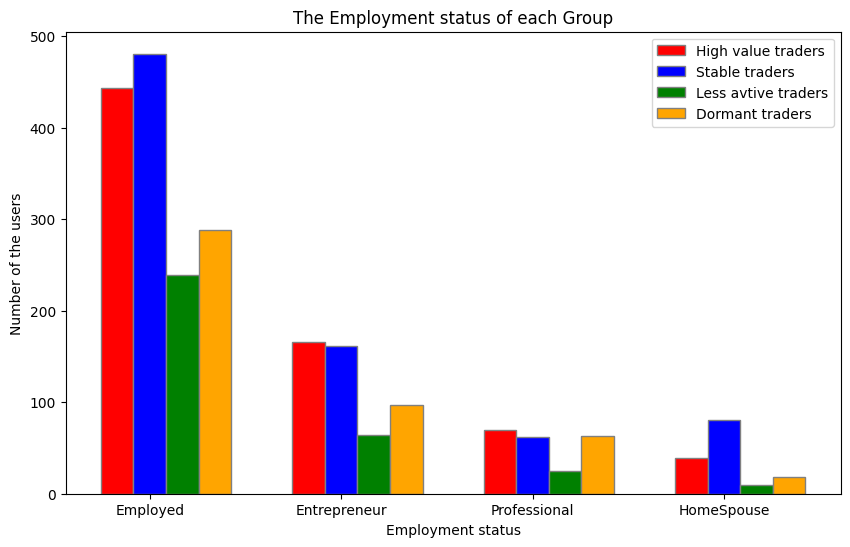

In [122]:
import matplotlib.pyplot as plt

# Data
categories = ['Employed', 'Entrepreneur', 'Professional', 'HomeSpouse']
hvt = [443, 166, 70, 39]  # Assuming percentages for demonstration
st = [481, 162, 62, 81]  # Assuming percentages for demonstration
lat = [239, 64, 25, 10]  # Assuming percentages for demonstration
dt = [288, 97, 63, 18]

# Plotting the bar chart
bar_width = 0.17  # width of the bars

index = range(len(categories))  # the label locations

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set position of bar on X axis
r1 = index
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
ax.bar(r1, hvt, color='red', width=bar_width, edgecolor='grey', label='High value traders')
ax.bar(r2, st, color='blue', width=bar_width, edgecolor='grey', label='Stable traders')
ax.bar(r3, lat, color='green', width=bar_width, edgecolor='grey', label='Less avtive traders')
ax.bar(r4, dt, color='orange', width=bar_width, edgecolor='grey', label='Dormant traders')

# Add xticks on the middle of the group bars
ax.set_xlabel('Employment status')
ax.set_xticks([r + bar_width for r in range(len(hvt))])
ax.set_xticklabels(categories)
ax.set_ylabel('Number of the users')
ax.set_title('The Employment status of each Group')

# Create legend & Show graphic
ax.legend()

# Show the plot
plt.show()


In [ ]:
user

In [ ]:
Employed = 0
Entrepreneur = 0
Professional = 0
HomeSpouse = 0
for i in cluster_3['identifier']:
    df_e_temp = user_inf[user_inf['identifier'] == i]
    if df_e_temp['employment_status'].values == 'Employed':
        Employed+=1
    elif df_e_temp['employment_status'].values == 'Entrepreneur':
        Entrepreneur+=1
    elif df_e_temp['employment_status'].values == 'Professional':
        Professional+=1
    elif df_e_temp['employment_status'].values == 'HomeSpouse':
        HomeSpouse+=1
    else:
        print(i)

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Employed', 'Entrepreneur', 'Professional', 'HomeSpouse']
hvt = [443, 166, 70, 39]  # Assuming percentages for demonstration
st = [481, 162, 62, 81]  # Assuming percentages for demonstration
lat = [239, 64, 25, 10]  # Assuming percentages for demonstration
dt = [288, 97, 63, 18]

# Plotting the bar chart
bar_width = 0.17  # width of the bars

index = range(len(categories))  # the label locations

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set position of bar on X axis
r1 = index
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
ax.bar(r1, hvt, color='red', width=bar_width, edgecolor='grey', label='High value traders')
ax.bar(r2, st, color='blue', width=bar_width, edgecolor='grey', label='Stable traders')
ax.bar(r3, lat, color='green', width=bar_width, edgecolor='grey', label='Less avtive traders')
ax.bar(r4, dt, color='orange', width=bar_width, edgecolor='grey', label='Dormant traders')

# Add xticks on the middle of the group bars
ax.set_xlabel('Employment status')
ax.set_xticks([r + bar_width for r in range(len(hvt))])
ax.set_xticklabels(categories)
ax.set_ylabel('Number of the users')
ax.set_title('The Employment status of each Group')

# Create legend & Show graphic
ax.legend()

# Show the plot
plt.show()


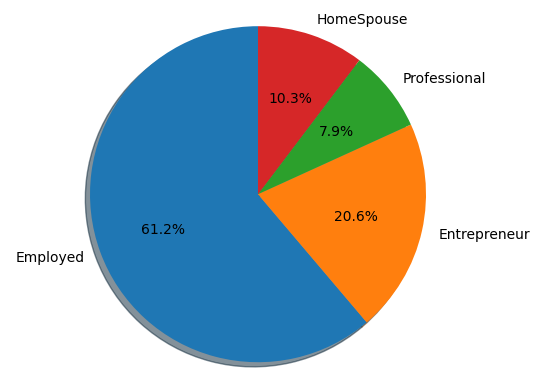

In [135]:
import matplotlib.pyplot as plt

# Define the data for the pie chart
labels = 'Employed', 'Entrepreneur', 'Professional', 'HomeSpouse'
hvt = [443, 166, 70, 39]  # Assuming percentages for demonstration
st = [481, 162, 62, 81]  # Assuming percentages for demonstration
lat = [239, 64, 25, 10]  # Assuming percentages for demonstration
dt = [288, 97, 63, 18]
explode = (0, 0, 0, 0)  # Only "explode" the 2nd slice (i.e. 'Hogs')

# Create a pie chart
fig1, ax1 = plt.subplots()
ax1.pie(st, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)


# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

# Display the plot
plt.show()


In [136]:
segment_event_tracked_sorted

,identifier,screen_name,event_tracked_at
0,1,ProfileScreen,2023-01-12 19:57:29.463
1,1,ProfileScreen,2022-08-16 09:25:05.78
2,1,FundsScreen,2022-09-28 12:24:59.263
3,1,BiometricPermissionScreen,2022-10-10 15:26:10.546
4,1,BiometricPermissionScreen,2022-09-28 12:24:35.35
...,...,...,...
4971555,2700,IsGotradeSafeScreen,2023-08-21 23:52:51.231
4971556,2700,IsGotradeSafeMainScreen,2023-08-21 23:52:51.23
4971557,2700,ProfileScreen,2023-08-22 00:14:58.262
4971558,2700,StockOrderSuccessScreen,2023-08-23 14:45:47.741


In [ ]:
Employed = 0
Entrepreneur = 0
Professional = 0
HomeSpouse = 0
for i in cluster_3['identifier']:
    df_e_temp = user_inf[user_inf['identifier'] == i]
    

In [171]:
temp_df_se = segment_event_tracked_sorted[segment_event_tracked_sorted['identifier'].isin(cluster_0['identifier'])]
Counter(temp_df_se['screen_name']).most_common(5)

[('SearchDiscoverScreen', 202576),
 ('StockOrderInputAmountScreen', 64876),
 ('FundsScreen', 46867),
 ('StockOrderConfirmScreen', 31273),
 ('ProfileScreen', 25885)]

In [221]:
temp_df_se = segment_event_tracked_sorted[segment_event_tracked_sorted['identifier'].isin(cluster_1['identifier'])]
Counter(temp_df_se['screen_name']).most_common(5)

[('SearchDiscoverScreen', 348444),
 ('StockOrderInputAmountScreen', 90410),
 ('FundsScreen', 65613),
 ('StockOrderConfirmScreen', 51142),
 ('StockOrderRequestLoadingScreen', 40119)]

In [175]:
temp_df_se = segment_event_tracked_sorted[segment_event_tracked_sorted['identifier'].isin(cluster_2['identifier'])]
Counter(temp_df_se['screen_name']).most_common(5)

[('SearchDiscoverScreen', 62124),
 ('FundsScreen', 22577),
 ('StockOrderInputAmountScreen', 14810),
 ('ProfileScreen', 13452),
 ('StockOrderConfirmScreen', 8548)]

In [218]:
temp_df_se = segment_event_tracked_sorted[segment_event_tracked_sorted['identifier'].isin(cluster_3['identifier'])]
Counter(temp_df_se['screen_name']).most_common(5)

[('SearchDiscoverScreen', 1221031),
 ('StockOrderInputAmountScreen', 431395),
 ('StockOrderConfirmScreen', 251657),
 ('StockOrderRequestLoadingScreen', 210715),
 ('StockOrderSuccessScreen', 200562)]

In [222]:
Counter(temp_df_se['screen_name'])['ProfileScreen']

38211

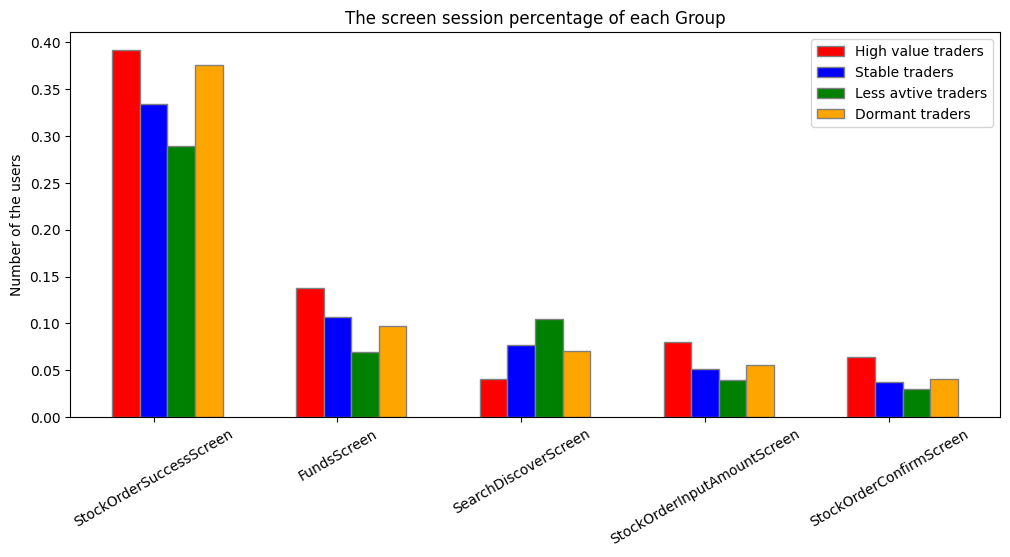

In [202]:
import matplotlib.pyplot as plt

# Data
categories = {'SearchDiscoverScreen',
              'StockOrderInputAmountScreen',
              'FundsScreen',
              'StockOrderConfirmScreen',
              'StockOrderSuccessScreen'}
hvt = [1221031, 431395, 125878, 251657,200562] # Assuming percentages for demonstration
st = [202576, 64876, 46867, 31273,22525] # Assuming percentages for demonstration
lat = [62124, 14810, 22577, 8548,6512] # Assuming percentages for demonstration
dt = [348444, 90410, 65613, 51142,37928]

hvt_result = [num / (3120748) for num in hvt]
st_result = [num / (606094) for num in st]
lat_result = [num / (214546) for num in lat]
dt_result = [num / (926674) for num in dt]

# Plotting the bar chart
bar_width = 0.15  # width of the bars

index = range(len(categories))  # the label locations

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(12, 5))

# Set position of bar on X axis
r1 = index
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Make the plot
plt.bar(r1, hvt_result, color='red', width=bar_width, edgecolor='grey', label='High value traders')
plt.bar(r2, st_result, color='blue', width=bar_width, edgecolor='grey', label='Stable traders')
plt.bar(r3, lat_result, color='green', width=bar_width, edgecolor='grey', label='Less avtive traders')
plt.bar(r4, dt_result, color='orange', width=bar_width, edgecolor='grey', label='Dormant traders')

# Add xticks on the middle of the group bars
plt.xlabel('')
plt.xticks([r + bar_width for r in range(len(hvt))],categories,rotation=30)
plt.ylabel('Number of the users')
plt.title('The screen session percentage of each Group')

# Create legend & Show graphic
plt.legend()

# Show the plot
plt.show()


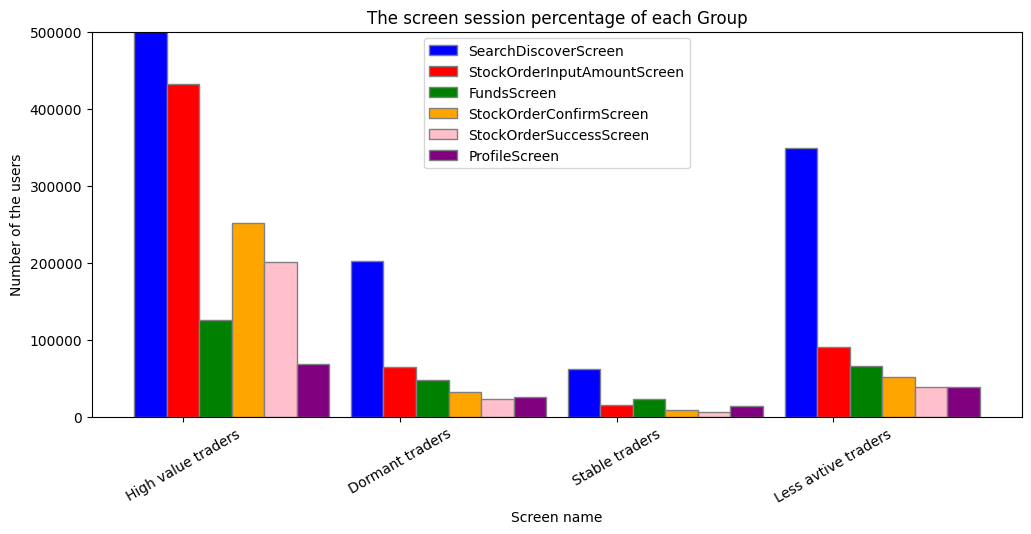

In [226]:
import matplotlib.pyplot as plt

# Data
categories = {'High value traders',
              'Stable traders',
              'Less avtive traders',
              'Dormant traders'}

SearchDiscoverScreen = [1221031, 202576, 62124, 348444] # Assuming percentages for demonstration
StockOrderInputAmountScreen = [431395, 64876, 14810, 90410] # Assuming percentages for demonstration
FundsScreen = [125878, 46867, 22577, 65613] # Assuming percentages for demonstration
StockOrderConfirmScreen = [251657, 31273, 8548, 51142]
StockOrderSuccessScreen = [200562,22525,6512,37928]
ProfileScreen = [67955,25885,13452,38211]

# Plotting the bar chart
bar_width = 0.15  # width of the bars

index = range(len(categories))  # the label locations

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(12, 5))

# Set position of bar on X axis
r1 = index
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Make the plot
plt.bar(r1, SearchDiscoverScreen, color='blue', width=bar_width, edgecolor='grey', label='SearchDiscoverScreen')
plt.bar(r2, StockOrderInputAmountScreen, color='red', width=bar_width, edgecolor='grey', label='StockOrderInputAmountScreen')
plt.bar(r3, FundsScreen, color='green', width=bar_width, edgecolor='grey', label='FundsScreen')
plt.bar(r4, StockOrderConfirmScreen, color='orange', width=bar_width, edgecolor='grey', label='StockOrderConfirmScreen')
plt.bar(r5, StockOrderSuccessScreen, color='pink', width=bar_width, edgecolor='grey', label='StockOrderSuccessScreen')
plt.bar(r6, ProfileScreen, color='purple', width=bar_width, edgecolor='grey', label='ProfileScreen')

# Add xticks on the middle of the group bars
plt.xlabel('Screen name')
plt.ylim([0, 500000])
plt.xticks([r + bar_width for r in range(len(SearchDiscoverScreen))],categories,rotation=30)
plt.ylabel('Number of the users')
plt.title('The screen session percentage of each Group')

# Create legend & Show graphic
plt.legend(loc=9)
#plt.xlim([0, 302576])
# Show the plot
plt.show()


In [227]:
df

,identifier,Total trading,Deposit,Buy,Trading frequency,Account setup time,Churn percentage,Session length
0,1,3.0,10.320000,9.940000,55.394352,2.11,0.0,29.0
1,2,17.0,23.840000,1.969231,3432.536691,28.85,0.0,515.0
2,3,11.0,16.135000,6.416667,965.519824,26.52,0.0,195.0
3,4,10.0,17.185000,6.456000,2689.766296,25.94,0.0,363.0
4,5,8.0,13.962500,15.248000,2508.149028,5.39,0.0,479.0
...,...,...,...,...,...,...,...,...
2304,2694,19.0,4.820000,2.112000,31.598958,0.78,0.0,33.0
2305,2695,20.0,14.575000,2.235882,10.696481,0.82,0.0,48.0
2306,2696,48.0,986.048333,150.157805,11.224264,2.89,0.0,88.0
2307,2698,9.0,147.555000,109.808000,18.262014,0.61,0.0,30.0


In [235]:
df[['identifier','Total trading']]

,identifier,Total trading
0,1,3.0
1,2,17.0
2,3,11.0
3,4,10.0
4,5,8.0
...,...,...
2304,2694,19.0
2305,2695,20.0
2306,2696,48.0
2307,2698,9.0


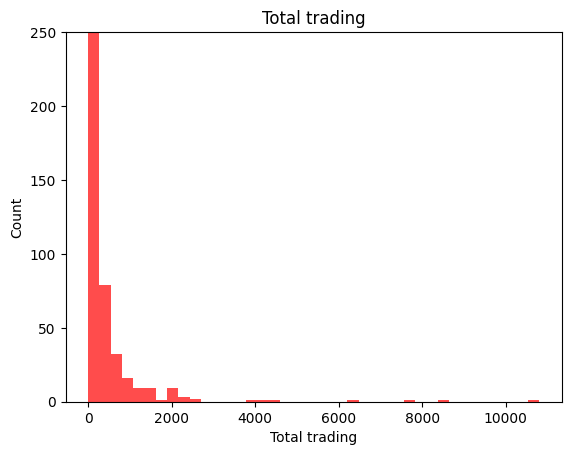

In [246]:
import matplotlib.pyplot as plt
plt.hist(df[['Total trading']],color = "red",bins=40,alpha = 0.7,label='Cluster 3')

plt.xlabel('Total trading') 
plt.ylabel('Count') 
plt.ylim([0, 250])
plt.show()

In [237]:
df_feature

,identifier,Total trading
1521,1765,2.0
2100,2428,2.0
2142,2480,2.0
38,50,2.0
2164,2507,2.0
...,...,...
604,713,4487.0
681,806,6408.0
675,799,7568.0
843,989,8553.0
